<a href="https://colab.research.google.com/github/gptakshitiz/Quora-Test/blob/main/New_Test_for_Indigo_CLEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--2025-07-04 15:10:08--  https://huggingface.co/datasets/toughdata/quora-question-answer-dataset/resolve/main/Quora-QuAD.jsonl
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.55, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/6a/02/6a02a59c5073e52530e7d27f048b54b1a6003eac7cffa3fe16e9966947a9cc17/1a56583136a87a6d7243e8be71d26fe826292b7c12694c91b51be87c574b4c57?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Quora-QuAD.jsonl%3B+filename%3D%22Quora-QuAD.jsonl%22%3B&Expires=1751645409&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTY0NTQwOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy82YS8wMi82YTAyYTU5YzUwNzNlNTI1MzBlN2QyN2YwNDhiNTRiMWE2MDAzZWFjN2NmZmEzZmUxNmU5OTY2OTQ3YTljYzE3LzFhNTY1ODMxMzZhODdhNmQ3MjQzZThiZTcxZDI2ZmU4MjYyOTJiN2MxMjY5NGM5MWI1MWJlODdjNTc0YjRjNT

100%|██████████| 56402/56402 [00:09<00:00, 6172.83it/s]


✅ CSVs saved:
- train_quora_clean.csv
- test_quora_clean.csv


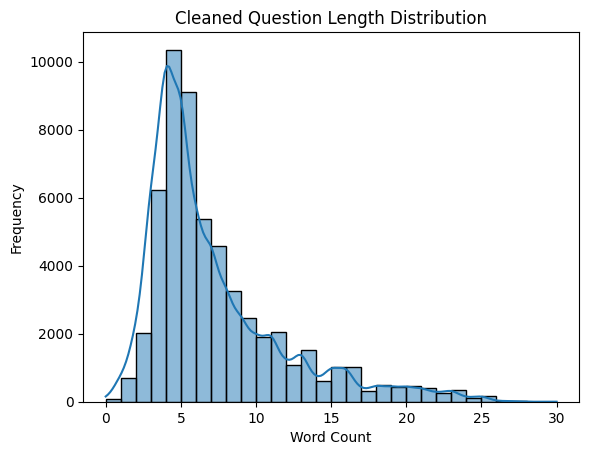

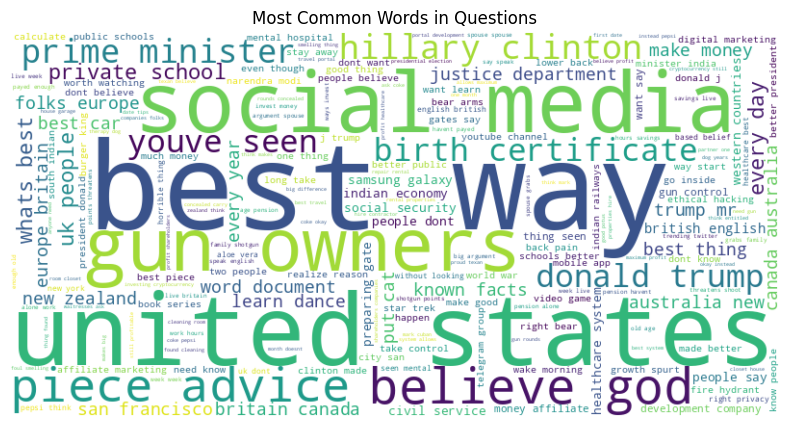

In [ ]:
# STEP 1: Install & Import
!pip install datasets nltk pandas matplotlib seaborn wordcloud --quiet


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from tqdm import tqdm
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))


# STEP 2: Download Dataset
!wget -O Quora-QuAD.jsonl https://huggingface.co/datasets/toughdata/quora-question-answer-dataset/resolve/main/Quora-QuAD.jsonl


df = pd.read_json("Quora-QuAD.jsonl", lines=True)
print("Shape:", df.shape)
print("Columns:", df.columns)
df.sample(2)


def clean_text(text):
   if not isinstance(text, str):
       return ""
   text = text.lower()
   text = re.sub(r'<.*?>', '', text)
   text = re.sub(r'[^a-z\s]', '', text)
   tokens = text.split()
   tokens = [w for w in tokens if w not in stop_words]
   return " ".join(tokens)


tqdm.pandas()
df['clean_question'] = df['question'].progress_apply(clean_text)
df['clean_answer'] = df['answer'].progress_apply(clean_text)


df[['clean_question', 'clean_answer']].head()






from sklearn.model_selection import train_test_split


# Only keep cleaned columns
clean_df = df[['clean_question', 'clean_answer']].dropna()


# Split: 90% train, 10% test
train_df, test_df = train_test_split(clean_df, test_size=0.1, random_state=42)


# Save to CSV
train_df.to_csv("train_quora_clean.csv", index=False)
test_df.to_csv("test_quora_clean.csv", index=False)


print("✅ CSVs saved:")
print("- train_quora_clean.csv")
print("- test_quora_clean.csv")


# Distribution of question lengths
clean_df['question_length'] = clean_df['clean_question'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['question_length'], bins=30, kde=True)
plt.title("Cleaned Question Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


# WordCloud for questions
question_words = " ".join(clean_df['clean_question'])
wordcloud_q = WordCloud(width=800, height=400, background_color='white').generate(question_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_q, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Questions")
plt.show()




# WordCloud for answers
answer_words = " ".join(clean_df['clean_answer'])
wordcloud_a = WordCloud(width=800, height=400, background_color='white').generate(answer_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_a, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Answers")
plt.show()


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Fit TF-IDF on train set questions
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['clean_question'])


def get_answer(query, top_k=1):
   query_clean = clean_text(query)
   query_vec = tfidf_vectorizer.transform([query_clean])
   similarity_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
   top_idx = similarity_scores.argsort()[-top_k:][::-1]


   for idx in top_idx:
       print(f"Q: {train_df.iloc[idx]['clean_question']}")
       print(f"A: {train_df.iloc[idx]['clean_answer']}")
       print(f"(Similarity: {similarity_scores[idx]:.3f})")
       print("------")


# 🔍 Example
get_answer("What is the capital of India?")


from transformers import pipeline


qa_pipeline = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")


result = qa_pipeline({
   'question': "Who is the founder of Facebook?",
   'context': "Mark Zuckerberg is the founder and CEO of Facebook."
})
print(result)
